imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from Butterflies.train.configParser import ConfigParser
from Butterflies.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath= "/raid/elhamod/Butterflies2/experiments/" # "/raid/elhamod/CIFAR_HGNN/experiments/"
dataPath="/raid/elhamod/Butterflies2/Datasets" #"/raid/elhamod/Fish" "/raid/elhamod/"
experimentName = "Butterflies_round1_1" 
trial_hash="b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d" #Best

legends=['fine', 'coarse']
use_submodel=False
dataset_name="test"
cuda=0
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 0


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Butterflies_round1_1', 'modelName': 'models/b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d', 'datasetName': 'datasplits/20f0713aa829f297aa689b1adefc4e7fe8a5024c8ffa1ae514fc5a6b', 'experimentHash': '4a0e39af4f060f2f574e151cef05ad796bf1ee4cdfb57874b792a579', 'trialHash': 'b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d', 'image_path': 'LowResolution', 'suffix': 'preprocessed', 'useCrossValidation': False, 'img_res': 224, 'augmented': True, 'batchSize': 264, 'learning_rate': 0.001, 'numOfTrials': 3, 'fc_layers': 1, 'pretrained': True, 'epochs': 120, 'patience': -1, 'optimizer': 'adabelief', 'scheduler': 'plateau', 'weightdecay': 0.01, 'scheduler_gamma': 0.5, 'scheduler_patience': 15, 'modelType': 'BB', 'lambda': 1.0, 'two_phase_lambda': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'tripletEnabled': True, 'regularTripletLoss': False, 'tripletSamples': 8, 'tripletSel

Get untrained model

In [5]:
%%capture

architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 81/81 [00:01<00:00, 80.03it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 3.312702
[t-SNE] Computed conditional probabilities in 0.017s
[t-SNE] Iteration 50: error = 53.8378448, gradient norm = 0.5816086 (50 iterations in 0.037s)
[t-SNE] Iteration 100: error = 53.1838531, gradient norm = 0.5729306 (50 iterations in 0.034s)
[t-SNE] Iteration 150: error = 52.6022797, gradient norm = 0.5824510 (50 iterations in 0.035s)
[t-SNE] Iteration 200: error = 54.2010841, gradient norm = 0.5835724 (50 iterations in 0.135s)
[t-SNE] Iteration 250: error = 52.0311737, gradient norm = 0.5902108 (50 iterations in 0.040s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.031174
[t-SNE] Iteration 300: error = 0.3628748, gradient norm = 0.0033038 (50 iterations in 0.038s)
[t-SNE] Iteration 350: error = 0.2935932, gradient norm = 0.0006162 (

100%|██████████| 322/322 [00:01<00:00, 187.14it/s]


comimics components: [ 0  1  2  3  4  2  5  6  6  7  8  9 10 11  9  3 12 13 14 15  0 16 17 15
 18  2 19 20  7  2 19  7 21 11 22 20 22 18]


100%|██████████| 81/81 [00:00<00:00, 84.86it/s] 


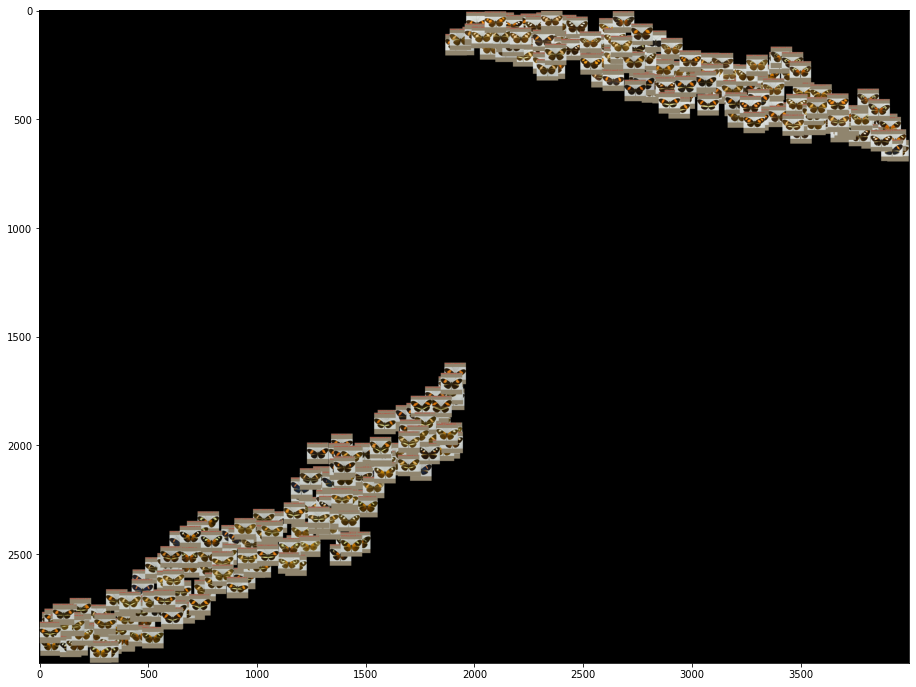

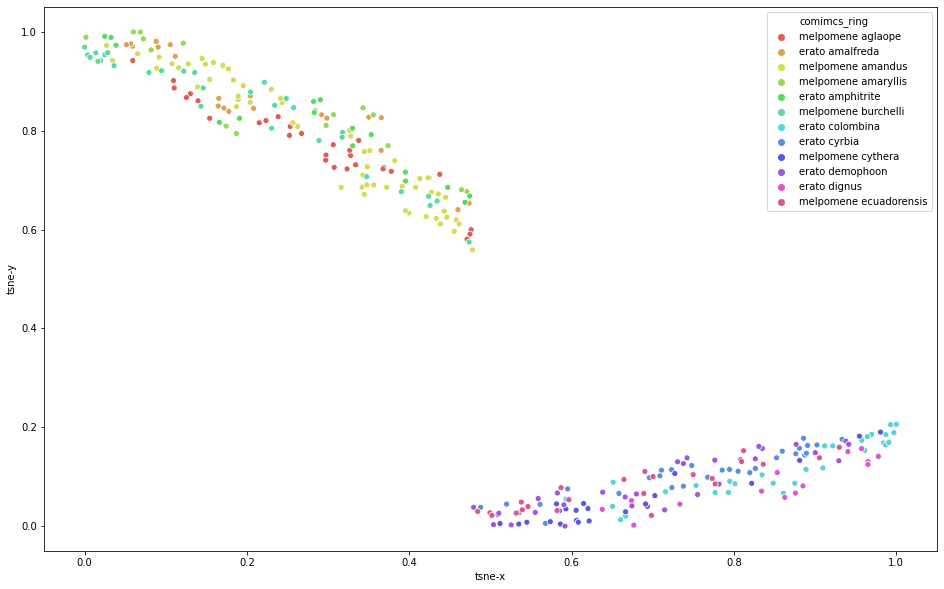

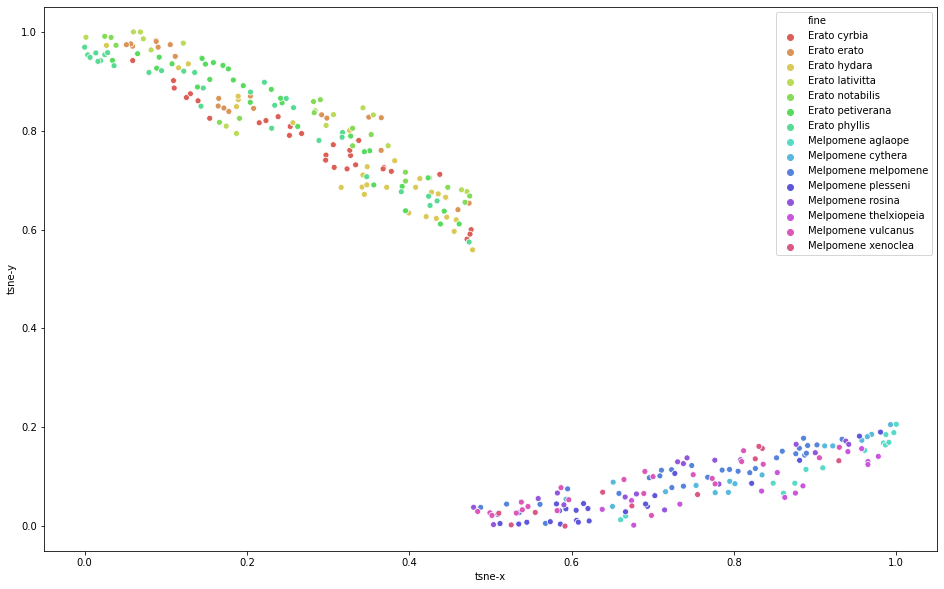

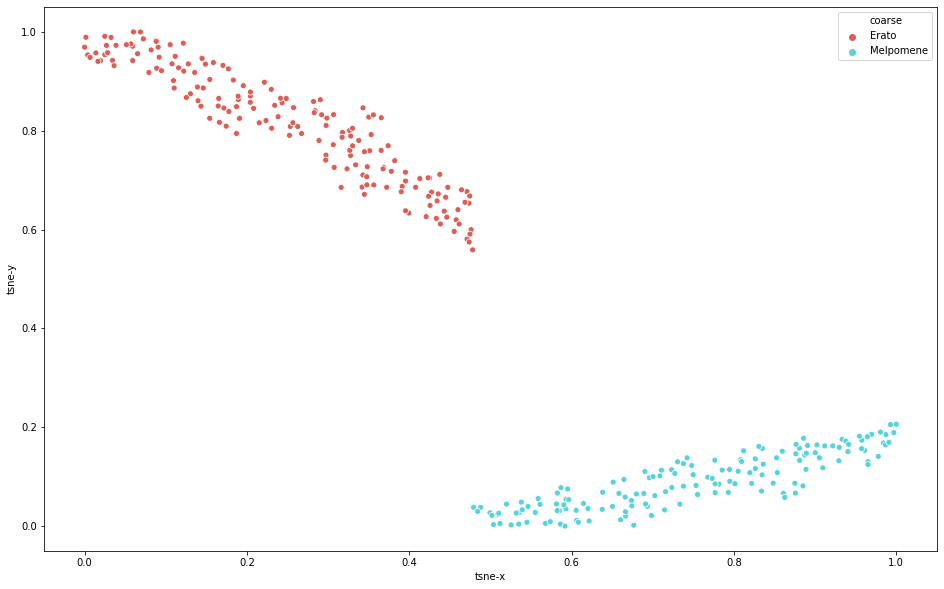

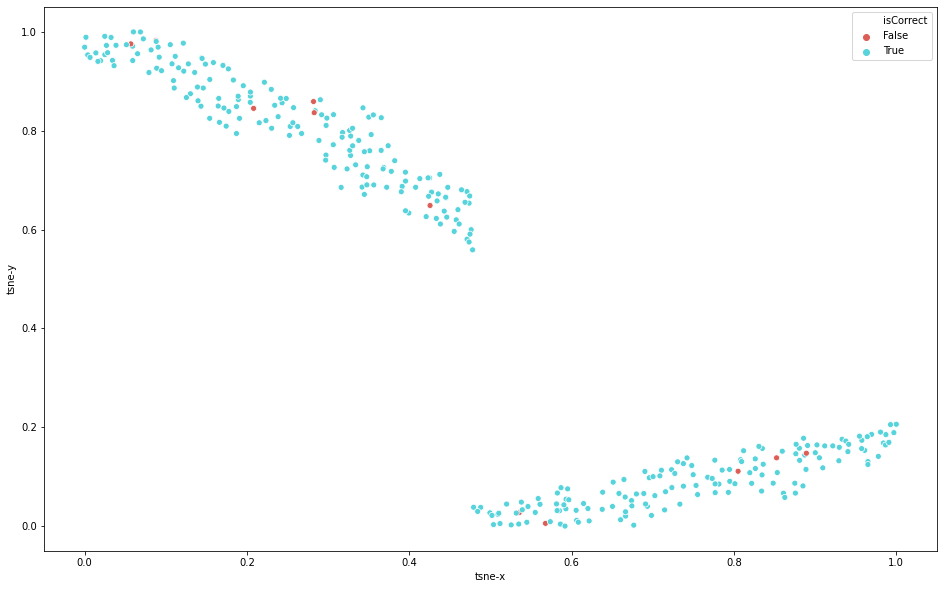

In [6]:
activation_layer = 'layer2'#'fine'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 81/81 [00:00<00:00, 82.03it/s] 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 27.789995
[t-SNE] Computed conditional probabilities in 0.017s
[t-SNE] Iteration 50: error = 54.8915520, gradient norm = 0.6164384 (50 iterations in 0.042s)
[t-SNE] Iteration 100: error = 57.6443901, gradient norm = 0.5624751 (50 iterations in 0.144s)
[t-SNE] Iteration 150: error = 57.2982063, gradient norm = 0.5922089 (50 iterations in 0.048s)
[t-SNE] Iteration 200: error = 56.2647018, gradient norm = 0.5716623 (50 iterations in 0.042s)
[t-SNE] Iteration 250: error = 57.1661720, gradient norm = 0.5709472 (50 iterations in 0.047s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.166172
[t-SNE] Iteration 300: error = 0.1811874, gradient norm = 0.0017223 (50 iterations in 0.043s)
[t-SNE] Iteration 350: error = 0.1634069, gradient norm = 0.0003353 

100%|██████████| 81/81 [00:00<00:00, 81.40it/s] 


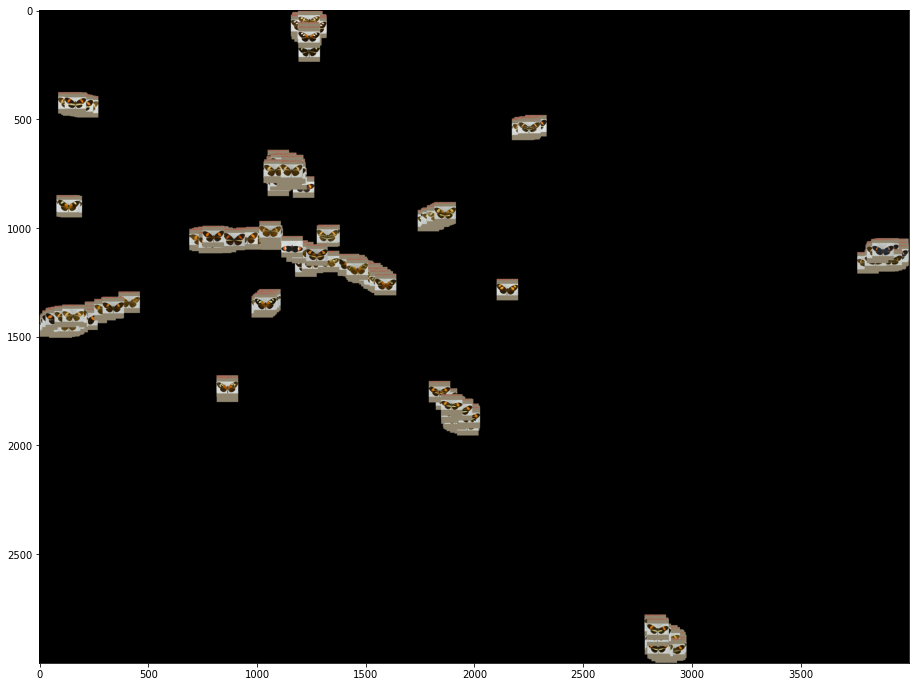

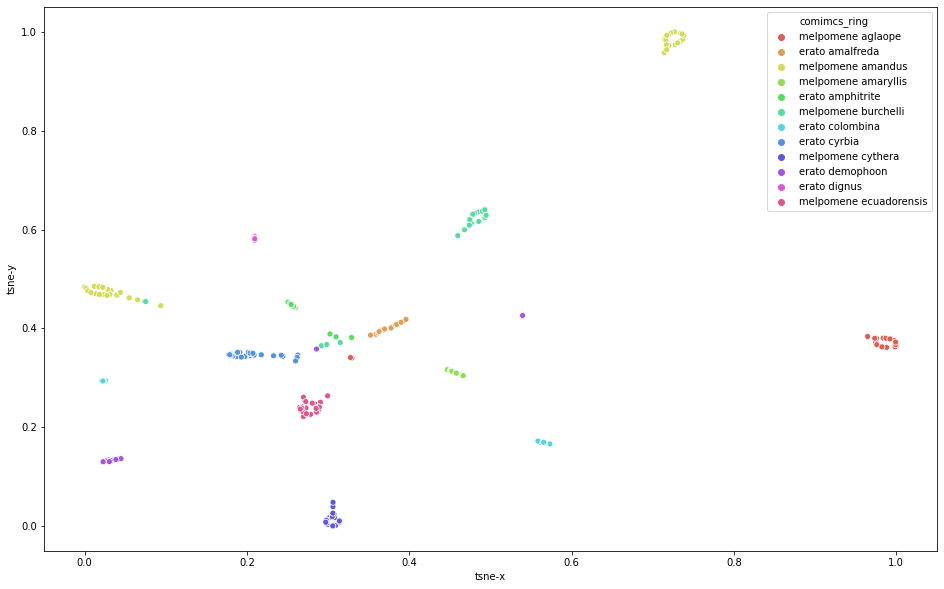

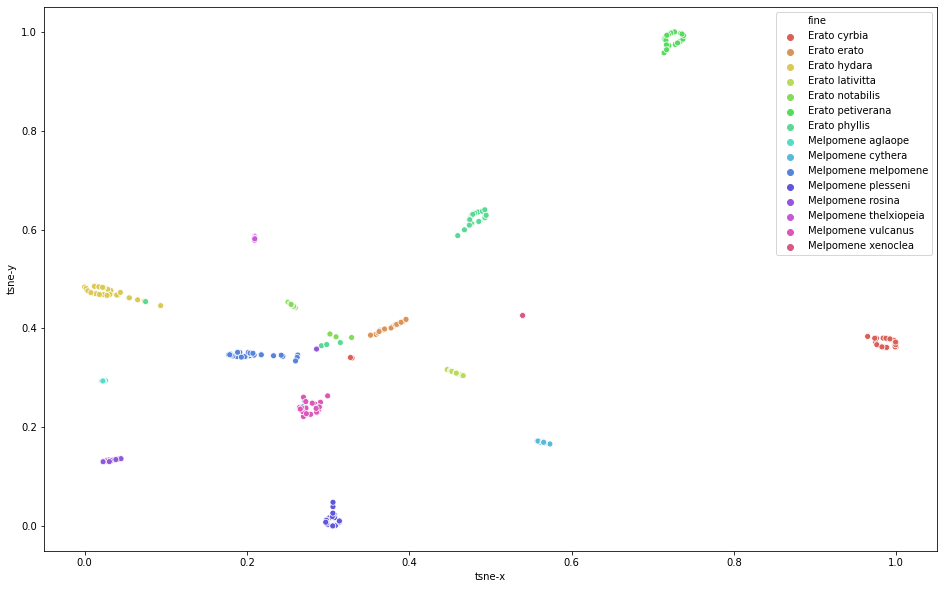

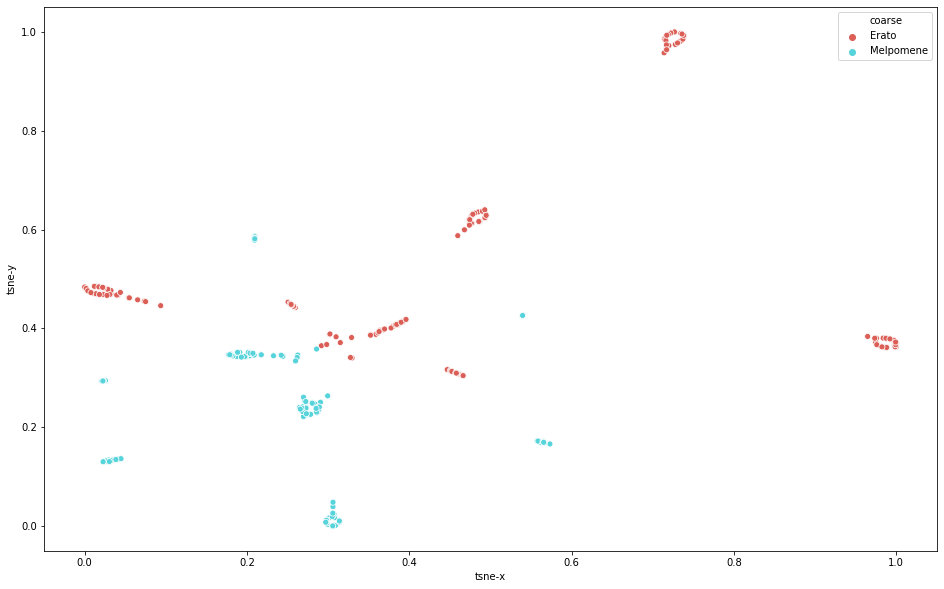

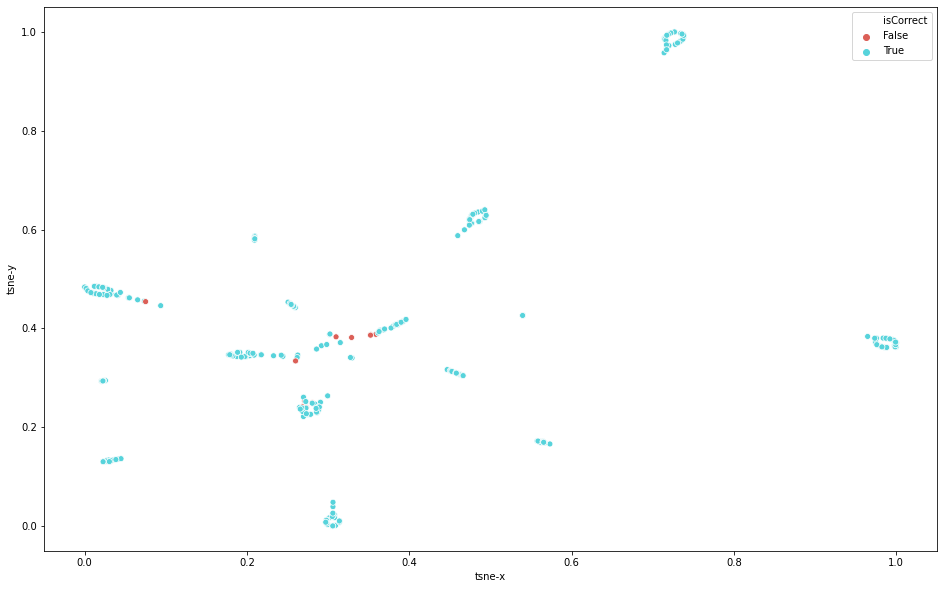

In [7]:
activation_layer = 'layer4'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 81/81 [00:00<00:00, 85.16it/s] 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 4.341312
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 56.2406502, gradient norm = 0.5733450 (50 iterations in 0.144s)
[t-SNE] Iteration 100: error = 54.9839134, gradient norm = 0.5879068 (50 iterations in 0.131s)
[t-SNE] Iteration 150: error = 53.9784775, gradient norm = 0.5657794 (50 iterations in 0.030s)
[t-SNE] Iteration 200: error = 52.7507248, gradient norm = 0.5688048 (50 iterations in 0.029s)
[t-SNE] Iteration 250: error = 54.2424545, gradient norm = 0.5614659 (50 iterations in 0.029s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.242455
[t-SNE] Iteration 300: error = 0.1395657, gradient norm = 0.0013102 (50 iterations in 0.028s)
[t-SNE] Iteration 350: error = 0.1298815, gradient norm = 0.0002700 (

100%|██████████| 81/81 [00:01<00:00, 75.69it/s] 


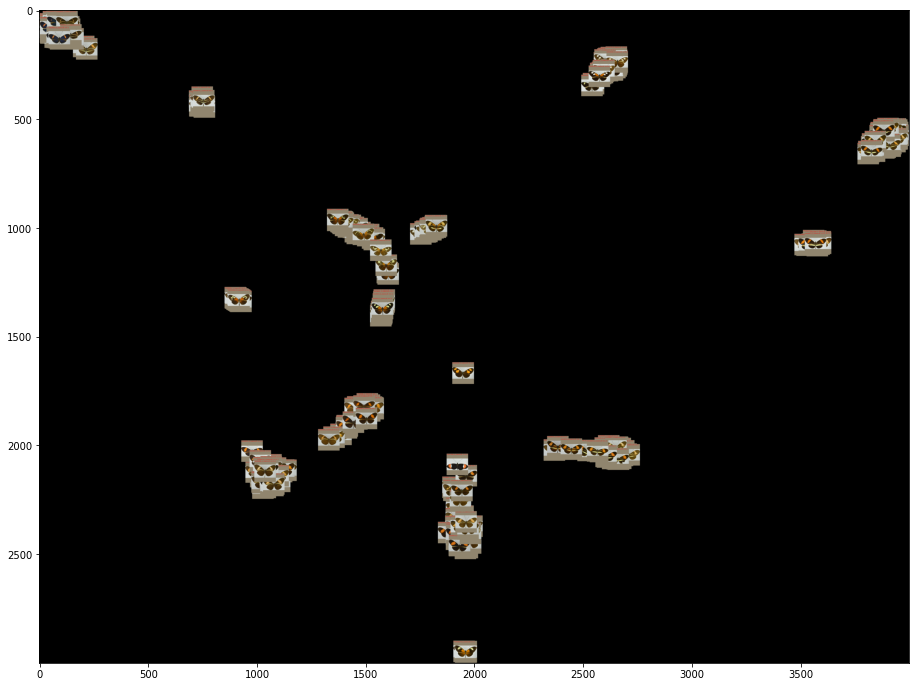

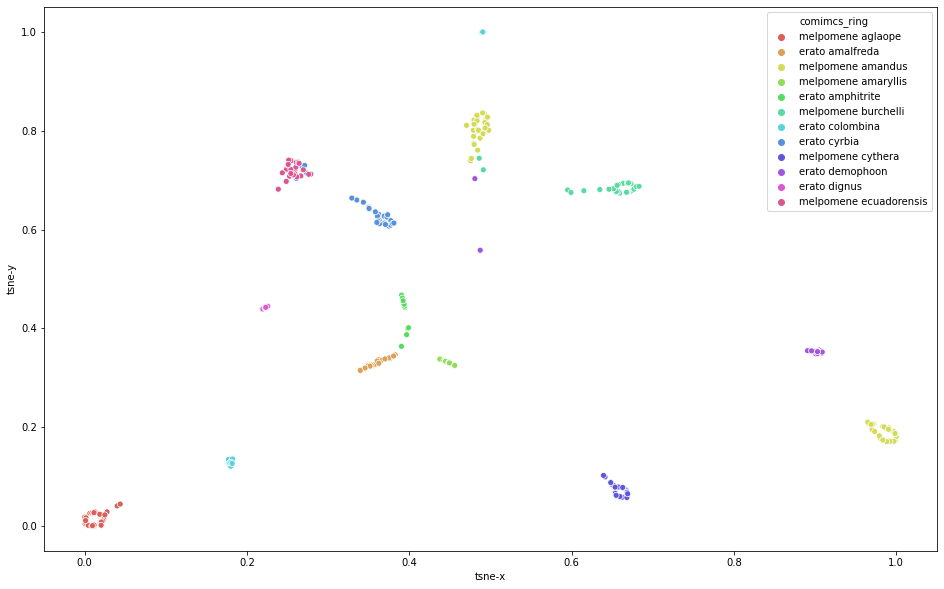

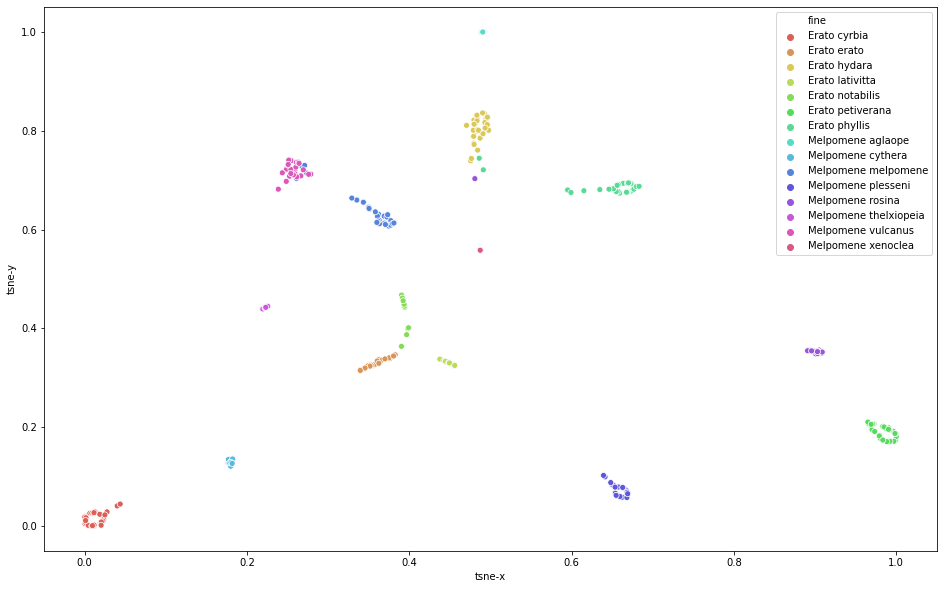

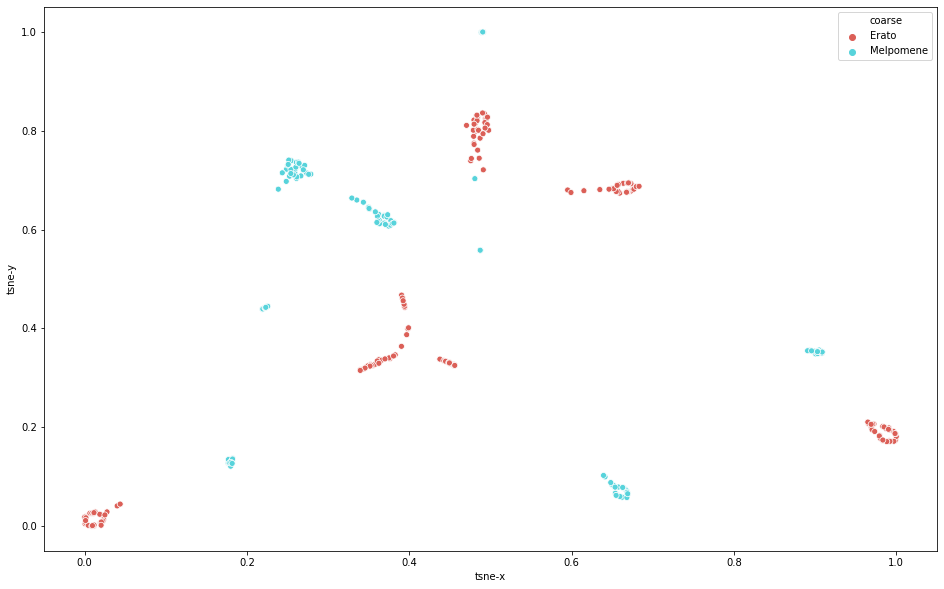

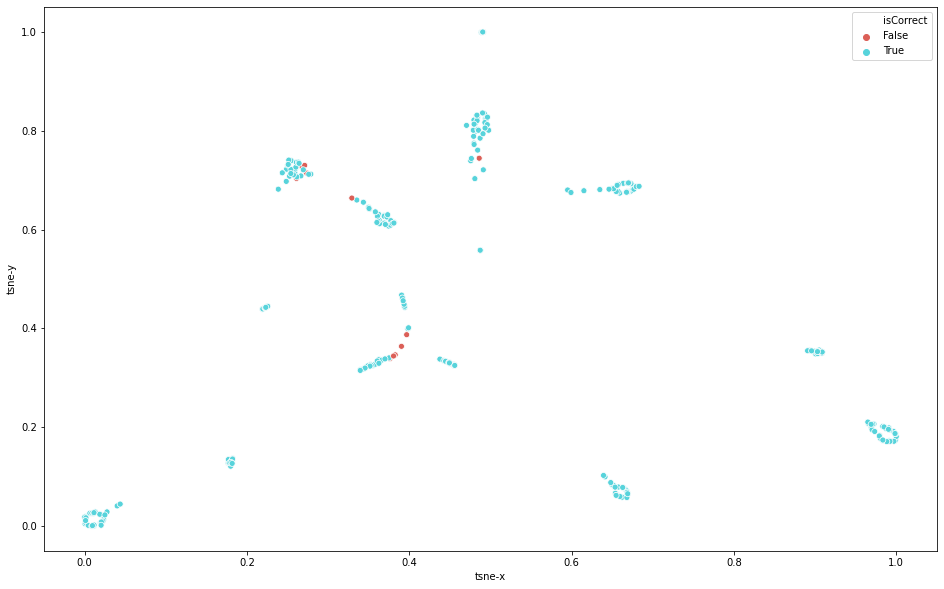

In [8]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)